In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50 #no. of complete passes of the training set through the algo.

## Load data into tf.dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

* 'Potato___Early_blight' = 0
* 'Potato___Late_blight' = 1
* 'Potato___healthy' = 2

In [5]:
len(dataset) #this gives 68 because data are stored in batches 2152/32

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 2 1 0 2 0 0 0 1 0 1 1 1 0 0 0 2 0 0 0 1 0 1 1 1 0 1]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[127. 115. 115.]
  [137. 125. 125.]
  [135. 123. 123.]
  ...
  [140. 126. 125.]
  [150. 136. 135.]
  [127. 113. 112.]]

 [[127. 115. 115.]
  [132. 120. 120.]
  [131. 119. 119.]
  ...
  [141. 127. 126.]
  [151. 137. 136.]
  [132. 118. 117.]]

 [[124. 112. 112.]
  [126. 114. 114.]
  [134. 122. 122.]
  ...
  [143. 129. 128.]
  [153. 139. 138.]
  [141. 127. 126.]]

 ...

 [[161. 150. 156.]
  [159. 148. 154.]
  [161. 150. 156.]
  ...
  [188. 178. 176.]
  [184. 174. 172.]
  [181. 171. 169.]]

 [[161. 150. 156.]
  [157. 146. 152.]
  [157. 146. 152.]
  ...
  [192. 182. 180.]
  [187. 177. 175.]
  [181. 171. 169.]]

 [[156. 145. 151.]
  [151. 140. 146.]
  [151. 140. 146.]
  ...
  [195. 185. 183.]
  [189. 179. 177.]
  [183. 173. 171.]]]


## Data visualization

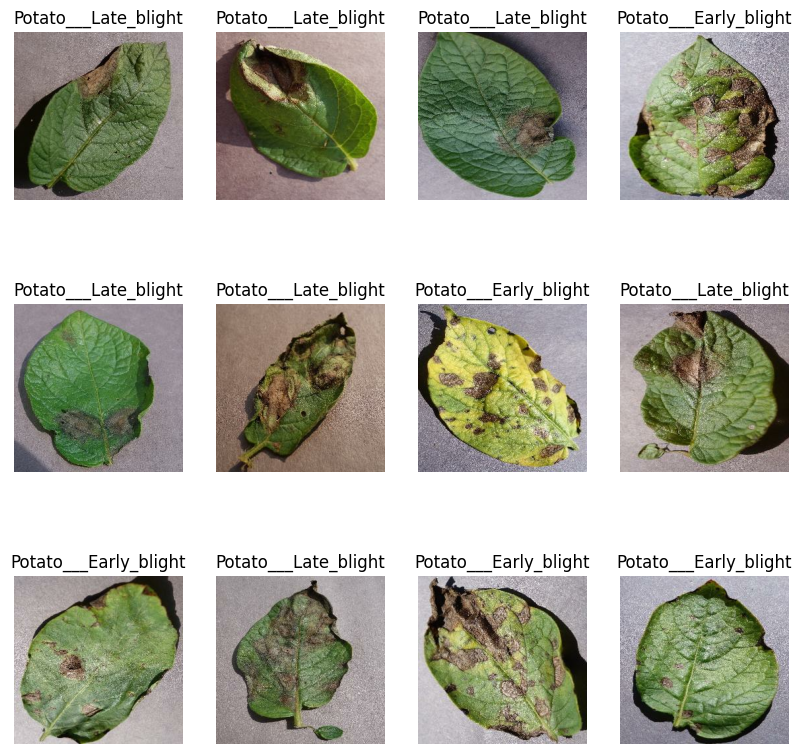

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        #have to convert float->int
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.axis("off") #remove axis
        plt.title(class_names[label_batch[i]]) #display which class it belongs

## Spliting the dataset
* Training -> 80%
* Validation -> 10% (Done after each Epoch)
* Test -> 10% (Done after model is completed)

In [9]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

train_ds = dataset.take(round(len(dataset)*train_size)) #54
remain_ds = dataset.skip(round(len(dataset)*train_size)) #14
val_ds = remain_ds.take(round(len(dataset)*val_size)) #7
test_ds = remain_ds.skip(round(len(dataset)*val_size)) #7

In [10]:
#function to split
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #to reproduce results

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(val_ds)

6

In [14]:
len(test_ds)

8

In [15]:
#cache a dataset, either in memory or on local storage
#prefetch will optimize by using cpu to prefetch next batch while gpu is training the current batch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data preprocessing
* Here resize and rescale done even though all the images from dataset is same, once predictions starts, user may enter different sizes

In [16]:
resize_with_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    #resize and rescale layer
    resize_with_rescale,
    
    #data augmentation layer
    data_augmentation,
    
    #convolutional layer
    #layers.Conv2D(no.layers, filter size, activation layer, input shape=255x255)
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),

    #pooling layer
    layers.MaxPooling2D((2, 2)),

    #stacking layers - have to check again
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #flatten into array of neuron
    layers.Flatten(),

    #dense layer of 64 neurons
    layers.Dense(64, activation='relu'),

    #last layer of 3 neurons with softmax - normalize the probability of classes
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Model compilation
* Use optimizer such as 'adam'
* Define loss function
* Then accuracy will be used as the metric to track the training process

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training the network

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4842 - loss: 0.9605 - val_accuracy: 0.6823 - val_loss: 0.8072
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6868 - loss: 0.6993 - val_accuracy: 0.7917 - val_loss: 0.5403
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7601 - loss: 0.5316 - val_accuracy: 0.7552 - val_loss: 0.5019
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8252 - loss: 0.4299 - val_accuracy: 0.8594 - val_loss: 0.3463
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8803 - loss: 0.2957 - val_accuracy: 0.9010 - val_loss: 0.2182
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9261 - loss: 0.2190 - val_accuracy: 0.8854 - val_loss: 0.2206
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9007 - loss: 0.2357 - val_accuracy: 0.9479 - val_loss: 0.2074
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9213 - loss: 0.2027 - val_accuracy: 0.9427 - val_loss:

In [24]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.9615 - loss: 0.1240


[0.15647073090076447, 0.95703125]

## Plotting training vs validation accuracy

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

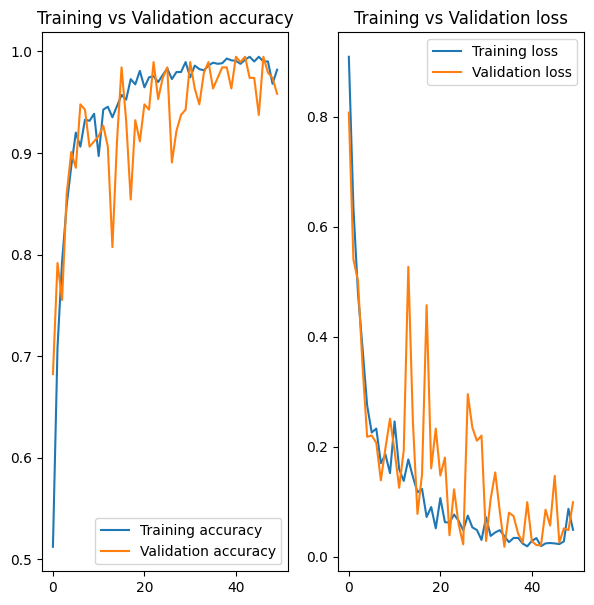

In [28]:
plt.figure(figsize=(7, 7))

#plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation accuracy')

#plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation loss')

plt.show()

In [ ]:
for images_batch, labels_batch in test_ds,take(1):
    first_img = images_batch